In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tabular-playground-series-apr-2021/sample_submission.csv
/kaggle/input/tabular-playground-series-apr-2021/train.csv
/kaggle/input/tabular-playground-series-apr-2021/test.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import sklearn
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import lightgbm
import lightgbm as lgb
import optuna

from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import warnings

pd.set_option("display.max_columns", None)

warnings.filterwarnings("ignore")


In [3]:
train=pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,1,"Oconnor, Frankie",male,NaN,2,0,209245,27.14,C12239,S
1,1,0,3,"Bryan, Drew",male,NaN,0,0,27323,13.35,NaN,S
2,2,0,3,"Owens, Kenneth",male,0.33,1,2,CA 457703,71.29,NaN,S
3,3,0,3,"Kramer, James",male,19.00,0,0,A. 10866,13.04,NaN,S
4,4,1,3,"Bond, Michael",male,25.00,0,0,427635,7.76,NaN,S


In [4]:
test=pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C


In [5]:
id_col = test['PassengerId']

In [6]:
submission = pd.read_csv("../input/tabular-playground-series-apr-2021/sample_submission.csv")

In [7]:
train.shape
test.shape

(100000, 12)

(100000, 11)

In [8]:
train.describe()
test.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,100000.000000,96708.000000,100000.000000,100000.000000,99866.00000
mean,49999.500000,0.427740,2.106910,38.355472,0.397690,0.454560,43.92933
std,28867.657797,0.494753,0.837727,18.313556,0.862566,0.950076,69.58882
min,0.000000,0.000000,1.000000,0.080000,0.000000,0.000000,0.68000
25%,24999.750000,0.000000,1.000000,25.000000,0.000000,0.000000,10.04000
50%,49999.500000,0.000000,2.000000,39.000000,0.000000,0.000000,24.46000
75%,74999.250000,1.000000,3.000000,53.000000,1.000000,1.000000,33.50000
max,99999.000000,1.000000,3.000000,87.000000,8.000000,9.000000,744.66000


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,100000.000000,100000.000000,96513.000000,100000.000000,100000.00000,99867.000000
mean,149999.500000,2.368930,30.565796,0.486550,0.49283,45.374804
std,28867.657797,0.878458,14.054634,0.771262,0.92360,65.204725
min,100000.000000,1.000000,0.080000,0.000000,0.00000,0.050000
25%,124999.750000,1.000000,21.000000,0.000000,0.00000,10.130000
50%,149999.500000,3.000000,27.000000,0.000000,0.00000,13.980000
75%,174999.250000,3.000000,40.000000,1.000000,1.00000,37.390000
max,199999.000000,3.000000,81.000000,8.000000,9.00000,680.700000


In [9]:
train_info = pd.DataFrame(train.dtypes, columns=['DataType'])
train_info["Missing value"]=train.isnull().sum()
train_info["Missing pct"]=round(train.isnull().sum()/len(train)*100, 2)
train_info

test_info = pd.DataFrame(test.dtypes, columns=['DataType'])
test_info["Missing value"]=test.isnull().sum()
test_info["Missing pct"]=round(test.isnull().sum()/len(test)*100, 2)
test_info

,DataType,Missing value,Missing pct
PassengerId,int64,0,0.00
Survived,int64,0,0.00
Pclass,int64,0,0.00
Name,object,0,0.00
Sex,object,0,0.00
Age,float64,3292,3.29
SibSp,int64,0,0.00
Parch,int64,0,0.00
Ticket,object,4623,4.62
Fare,float64,134,0.13


,DataType,Missing value,Missing pct
PassengerId,int64,0,0.00
Pclass,int64,0,0.00
Name,object,0,0.00
Sex,object,0,0.00
Age,float64,3487,3.49
SibSp,int64,0,0.00
Parch,int64,0,0.00
Ticket,object,5181,5.18
Fare,float64,133,0.13
Cabin,object,70831,70.83


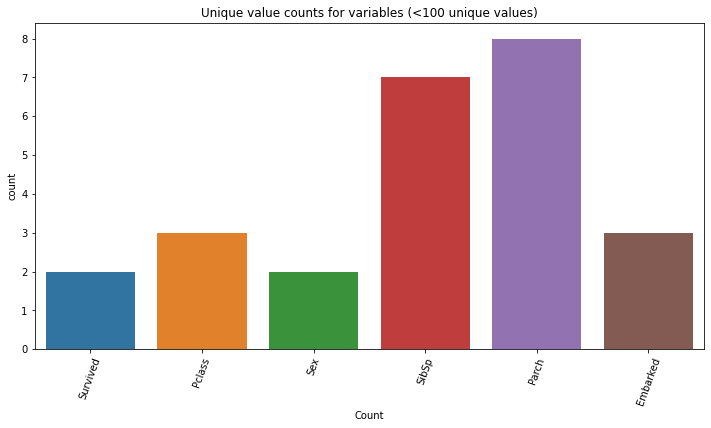

In [10]:
plt.figure(figsize=(12, 6))
vals_data=train.drop(['PassengerId','Name','Ticket','Fare','Cabin','Age'], axis=1)
unique_vals = vals_data.nunique().reset_index(name="count")
sns.barplot(x=unique_vals["index"], y=unique_vals["count"])
plt.xticks(rotation=70)
plt.xlabel('Count')
plt.title("Unique value counts for variables (<100 unique values)")
plt.show();

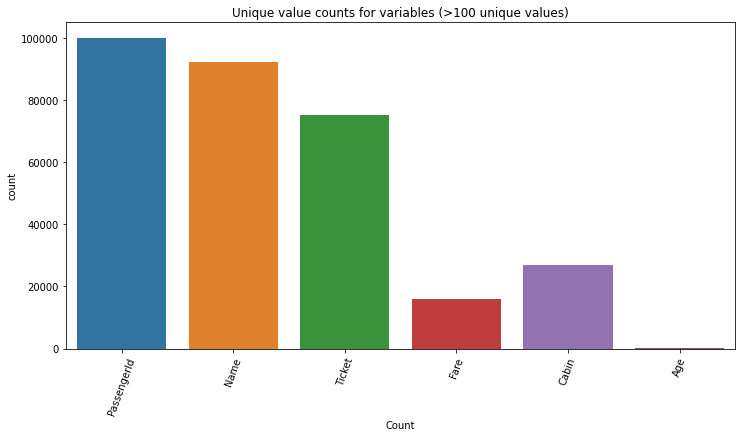

In [11]:
plt.figure(figsize=(12, 6))
vals_data1=train[['PassengerId','Name','Ticket','Fare','Cabin','Age']]
unique_vals = vals_data1.nunique().reset_index(name="count")
sns.barplot(x=unique_vals["index"], y=unique_vals["count"])
plt.xticks(rotation=70)
plt.xlabel('Count')
plt.title("Unique value counts for variables (>100 unique values)")
plt.show();

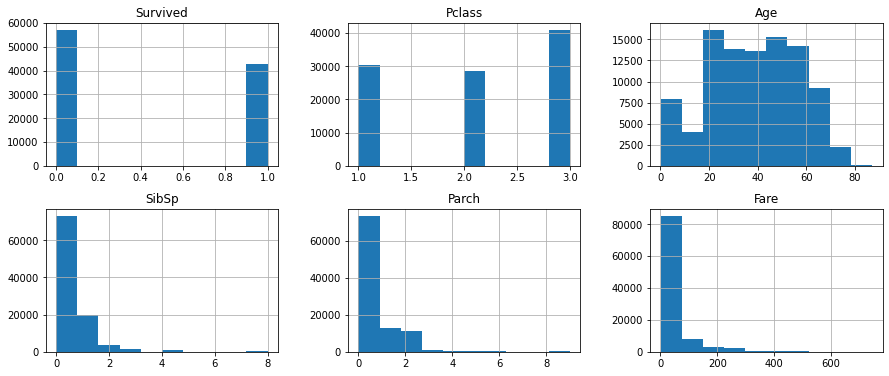

In [12]:
train.drop(['PassengerId'], axis=1).hist(figsize=(15, 30), layout=(9, 3));

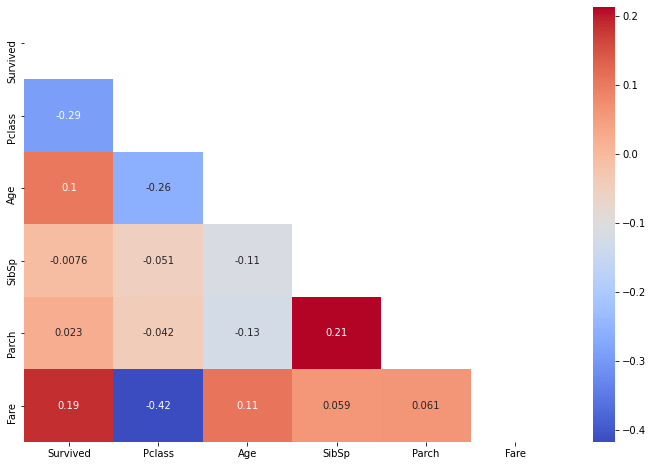

In [13]:
data_for_corr = train.drop('PassengerId', axis=1).corr()
corr_matrix = data_for_corr
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm")
plt.show();

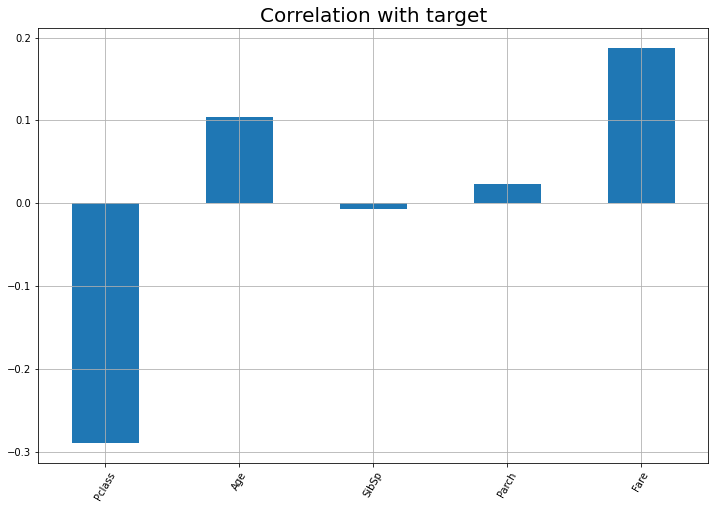

In [14]:
draw = train.drop(['PassengerId','Survived'], axis=1)
draw.corrwith(train['Survived']).plot(kind="bar", grid=True, figsize=(12, 8))
plt.title("Correlation with target", size=20)
plt.xticks(size=10, rotation=60)
plt.yticks(size=10)
plt.show();

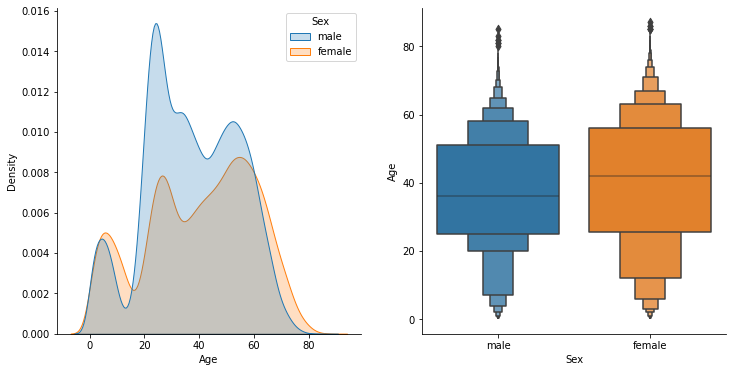

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
#sns.set_style('ticks')

sns.kdeplot(data=train, x='Age', hue='Sex', fill=True, ax=ax[0])
sns.boxenplot(data=train, x='Sex', y='Age', ax=ax[1])

sns.despine()
plt.show();

0    57226
1    42774
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

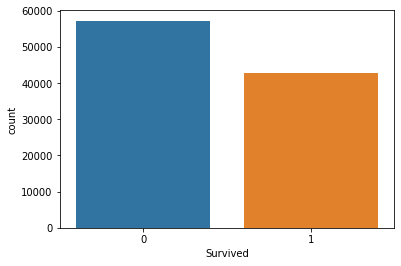

In [16]:
train["Survived"].value_counts()
sns.countplot(x="Survived",data=train)

Sex     Survived
female  1           31226
        0           12660
male    0           44566
        1           11548
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

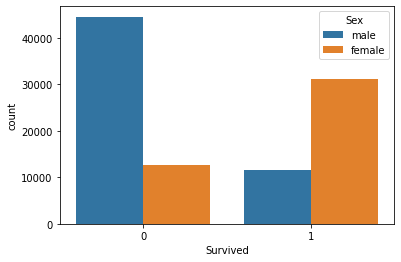

In [17]:
train.groupby("Sex")["Survived"].value_counts()
sns.countplot(x="Survived",hue='Sex',data=train)

<AxesSubplot:xlabel='Survived', ylabel='count'>

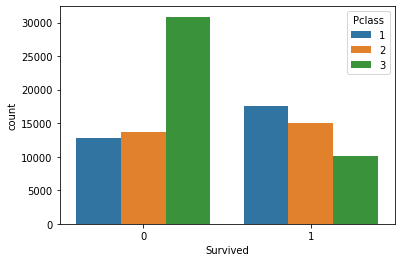

In [18]:
sns.countplot(x="Survived",hue='Pclass',data=train)

Embarked  Survived
C         1           16669
          0            5518
Q         1            3238
          0            2186
S         0           49394
          1           22745
Name: Survived, dtype: int64

<AxesSubplot:xlabel='Survived', ylabel='count'>

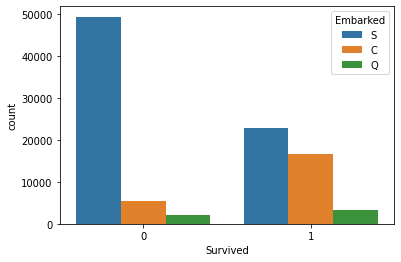

In [19]:
train.groupby("Embarked")["Survived"].value_counts()
sns.countplot(x="Survived",hue="Embarked",data=train)

In [20]:
#data = [train, test]
#for dataset in data:
#    dataset['AnyMissing'] = np.where(dataset.isnull().any(axis=1) == True, 1, 0)

In [21]:
data = [train, test]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']

In [22]:
data = [train, test]
for dataset in data:
    dataset['Fam size'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset['Fam size'] = dataset['Fam size'].apply(lambda x: 'VeryBig' if x >= 12 else 'Big' if x >= 8 else 'Medium' if x >= 5 else 'Small' if x >= 3 else 'Couple' if x ==2 else 'Alone')

In [23]:
data = [train, test]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(dataset['Embarked'].mode()[0])

In [24]:
train.groupby(['Sex', 'Pclass'])['Age'].agg(['mean','median']).reset_index()

,Sex,Pclass,mean,median
0,female,1,46.995091,49.0
1,female,2,39.324223,40.0
2,female,3,31.973681,28.0
3,male,1,42.254922,44.0
4,male,2,37.839926,37.0
5,male,3,34.038757,31.0


In [25]:
#data = [train, test]
#for dataset in data:
#    dataset.loc[(dataset['Age'].isna()) & (dataset['Sex'] == 'female') & (dataset['Pclass']==1), 'Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).reset_index().iloc[0,3]
#    dataset.loc[(dataset['Age'].isna()) & (dataset['Sex'] == 'female') & (dataset['Pclass']==2), 'Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).reset_index().iloc[1,3]
#    dataset.loc[(dataset['Age'].isna()) & (dataset['Sex'] == 'female') & (dataset['Pclass']==3), 'Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).reset_index().iloc[2,3]
#    dataset.loc[(dataset['Age'].isna()) & (dataset['Sex'] == 'male') & (dataset['Pclass']==1), 'Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).reset_index().iloc[3,3]
#    dataset.loc[(dataset['Age'].isna()) & (dataset['Sex'] == 'male') & (dataset['Pclass']==2), 'Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).reset_index().iloc[4,3]
#    dataset.loc[(dataset['Age'].isna()) & (dataset['Sex'] == 'male') & (dataset['Pclass']==3), 'Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).reset_index().iloc[5,3]


In [26]:
data=[train, test]

for dataset in data:
    k=0
    while k<6:
        for i in ['female', 'male']:
            for j in range(1,4):
                dataset.loc[(dataset['Age'].isna()) & (dataset['Sex'] == i) & (dataset['Pclass']==j), 'Age'] = dataset.groupby(['Sex', 'Pclass'])['Age'].agg(['mean', 'median']).reset_index().iloc[k,3]
                k=k+1

In [27]:
train.groupby(['Pclass','Embarked'])['Fare'].agg(['mean', 'median']).reset_index()

,Pclass,Embarked,mean,median
0,1,C,107.631413,73.040
1,1,Q,92.629576,68.480
2,1,S,80.613517,37.955
3,2,C,31.704657,26.075
4,2,Q,34.688181,24.420
5,2,S,23.720327,21.245
6,3,C,28.089859,19.740
7,3,Q,25.682521,10.990
8,3,S,19.631855,10.760


In [28]:
#k=0
#while k<9:
#    for i in range(1,4):
#        for j in ['C','Q','S']:
#            print(str(i),j,k)
#            k=k+1

In [29]:
data = [train, test]
for dataset in data:
    k=0
    while k<9:
        for i in range(1,4):
            for j in ['C','Q','S']:
                dataset.loc[(dataset['Fare'].isna()) & (dataset['Pclass']==i) & (dataset['Embarked']==j), 'Fare'] = round(dataset.groupby(['Pclass','Embarked'])['Fare'].agg(['mean', 'median']).reset_index().iloc[k,3], 2)
                k=k+1


In [30]:
#data = [train, test]
#for dataset in data:
#    dataset['avg fare'] = round(dataset['Fare'] / (dataset['Fam size']), 2)

In [31]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   PassengerId  100000 non-null  int64  
 1   Survived     100000 non-null  int64  
 2   Pclass       100000 non-null  int64  
 3   Name         100000 non-null  object 
 4   Sex          100000 non-null  object 
 5   Age          100000 non-null  float64
 6   SibSp        100000 non-null  int64  
 7   Parch        100000 non-null  int64  
 8   Ticket       95377 non-null   object 
 9   Fare         100000 non-null  float64
 10  Cabin        32134 non-null   object 
 11  Embarked     100000 non-null  object 
 12  relatives    100000 non-null  int64  
 13  Fam size     100000 non-null  object 
dtypes: float64(2), int64(6), object(6)
memory usage: 10.7+ MB


In [32]:
#pd.qcut(train['Age'], q=6).head()

In [33]:
#data = [train, test]
#for dataset in data:
#    dataset.loc[dataset['Age']<=21, 'Age'] = 1
#    dataset.loc[(dataset['Age']>21) & (dataset['Age']<=29), 'Age'] = 2
#    dataset.loc[(dataset['Age']>29) & (dataset['Age']<=38), 'Age'] = 3
#    dataset.loc[(dataset['Age']>38) & (dataset['Age']<=49), 'Age'] = 4
#    dataset.loc[(dataset['Age']>49) & (dataset['Age']<=57), 'Age'] = 5
#    dataset.loc[dataset['Age']>57, 'Age'] = 6

In [34]:
data = [train, test]
for dataset in data:
    dataset.loc[dataset['Age'] <= 9, 'Age'] = 1
    dataset.loc[(dataset['Age'] > 9) & (dataset['Age'] <=19), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 19) & (dataset['Age'] <=29), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 29) & (dataset['Age'] <=39), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 39) & (dataset['Age'] <=49), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 49) & (dataset['Age'] <=59), 'Age'] = 6
    dataset.loc[(dataset['Age'] > 59) & (dataset['Age'] <=69), 'Age'] = 7
    dataset.loc[(dataset['Age'] > 69) & (dataset['Age'] <=79), 'Age'] = 8
    dataset.loc[(dataset['Age'] > 79) & (dataset['Age'] <=89), 'Age'] = 9
    dataset.loc[(dataset['Age'] > 89) & (dataset['Age'] <=99), 'Age'] = 10

In [35]:
#pd.qcut(train['Fare'], q=5).head()

In [36]:
#data = [train, test]
#for dataset in data:
#    dataset.loc[dataset['Fare']<=9.31, 'Fare'] = 1
#    dataset.loc[(dataset['Fare']>9.31) & (dataset['Fare']<=13.51), 'Fare'] = 2
#    dataset.loc[(dataset['Fare']>13.51) & (dataset['Fare']<=27.85), 'Fare'] = 3
#    dataset.loc[(dataset['Fare']>27.85) & (dataset['Fare']<=60.13), 'Fare'] = 4
#    dataset.loc[dataset['Fare']>60.13, 'Fare'] = 5

In [37]:
data = [train, test]
for dataset in data: 
    dataset['Fare'] = dataset['Fare'].apply(lambda x: 'CrazyRich' if x >= 640 else 'UltraRich' if x >= 320 else 'VeryRich' if x >= 160 else 'Rich' if x >= 80 else 'SlightlyRich' if x >= 40 else 'SlightlyPoor' if x >= 20 else 'Poor' if x >= 10 else 'VeryPoor' if x >= 5 else 'UltraPoor')

In [38]:
train['Fare'].value_counts()

SlightlyPoor    34665
VeryPoor        23501
Poor            18945
SlightlyRich     9027
Rich             6496
VeryRich         4912
UltraRich        1232
UltraPoor        1183
CrazyRich          39
Name: Fare, dtype: int64

In [39]:
#data = [train, test]
#for dataset in data:
#    dataset['Avg Fare'] = round(dataset['Fare']/(dataset['SibSp'] + dataset['Parch'] + 1), 2)

In [40]:
#data = [train, test]
#for dataset in data:
#    dataset['Age_class'] = dataset['Age']*dataset['Pclass']

In [41]:
data = [train, test]
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna('N')
    dataset['Cabin'] = dataset["Cabin"].str[0]

In [42]:
data = [train, test]
for dataset in data:
    dataset['Name_len'] = (dataset['Name'].map(lambda x: x.split(', ')[0])+dataset['Name'].map(lambda x: x.split(', ')[1])).str.len()

In [43]:
data = [train, test]
for dataset in data:
    dataset['Name_len'] = dataset['Name_len'].apply(lambda x: 1 if x <= 7 else 2 if x < 12 else 3 if x < 15 else 4 if x < 20 else 5)

In [44]:
data = [train, test]
for dataset in data:
    dataset["last_name"] = dataset["Name"].apply(lambda x: x.split(",")[0])

In [45]:
train['last_name'].value_counts()

Smith        1162
Johnson       950
Williams      733
Jones         681
Brown         665
             ... 
Dahlberg        1
Weidman         1
Mccommons       1
Sughrue         1
Sittloh         1
Name: last_name, Length: 21558, dtype: int64

In [46]:
LastName = train['last_name'].append(test['last_name']).value_counts()
LastName = LastName.apply(lambda x: 'UltraCommon' if x >= 512 else 'VeryCommon' if x >= 256 else 'ModeratelyCommon' if x >= 128 else 'Common' if x >= 64 else 'SlightlyCommon' if x >= 32 else 'SlightlyRare' if x >= 16 else 'Rare' if x >= 8 else 'ModeratelyRare' if x >= 4 else 'VeryRare' if x >= 2 else 'UltraRare')
train['last_name'] = train['last_name'].apply(lambda x: LastName[x])
test['last_name'] = test['last_name'].apply(lambda x: LastName[x])

In [47]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
data = [train, test]
for dataset in data:
    dataset['Ticket_extracted']=dataset['Ticket'].fillna('0').str.extract('(\d+)')
    dataset['Ticket_extracted'] = sc.fit_transform(dataset[['Ticket_extracted']])

In [48]:
train_new=train.drop(['PassengerId','Name','Ticket'], axis=1)
test_new=test.drop(['PassengerId','Name','Ticket'], axis=1)

In [49]:
train_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,relatives,Fam size,Name_len,last_name,Ticket_extracted
0,1,1,male,5.0,2,0,SlightlyPoor,C,S,2,Small,3,SlightlyCommon,-0.137388
1,0,3,male,4.0,0,0,Poor,N,S,0,Alone,2,SlightlyCommon,-0.363655
2,0,3,male,1.0,1,2,SlightlyRich,N,S,3,Small,3,ModeratelyCommon,0.171633
3,0,3,male,2.0,0,0,Poor,N,S,0,Alone,2,SlightlyCommon,-0.384123
4,1,3,male,3.0,0,0,VeryPoor,N,S,0,Alone,2,SlightlyCommon,0.134235


In [50]:
le = preprocessing.LabelEncoder()
cat_cols = [feature for feature in train_new.select_dtypes('object')]
data = [train_new, test_new]
for dataset in data:
    for enc in cat_cols:
        dataset[enc]=le.fit_transform(dataset[enc])

In [51]:
train_new.head()
test_new.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,relatives,Fam size,Name_len,last_name,Ticket_extracted
0,1,1,1,5.0,2,0,3,2,2,2,4,3,4,-0.137388
1,0,3,1,4.0,0,0,1,7,2,0,0,2,4,-0.363655
2,0,3,1,1.0,1,2,4,7,2,3,4,3,1,0.171633
3,0,3,1,2.0,0,0,1,7,2,0,0,2,4,-0.384123
4,1,3,1,3.0,0,0,7,7,2,0,0,2,4,0.134235


,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,relatives,Fam size,Name_len,last_name,Ticket_extracted
0,3,1,2.0,0,0,4,7,2,0,0,3,5,-0.366818
1,3,0,6.0,0,0,7,7,2,0,0,3,0,-0.380616
2,1,0,2.0,0,0,3,1,0,0,0,3,8,-0.365322
3,2,1,3.0,0,0,1,7,2,0,0,2,4,-0.019176
4,1,0,2.0,0,2,3,1,0,2,4,2,3,-0.365066


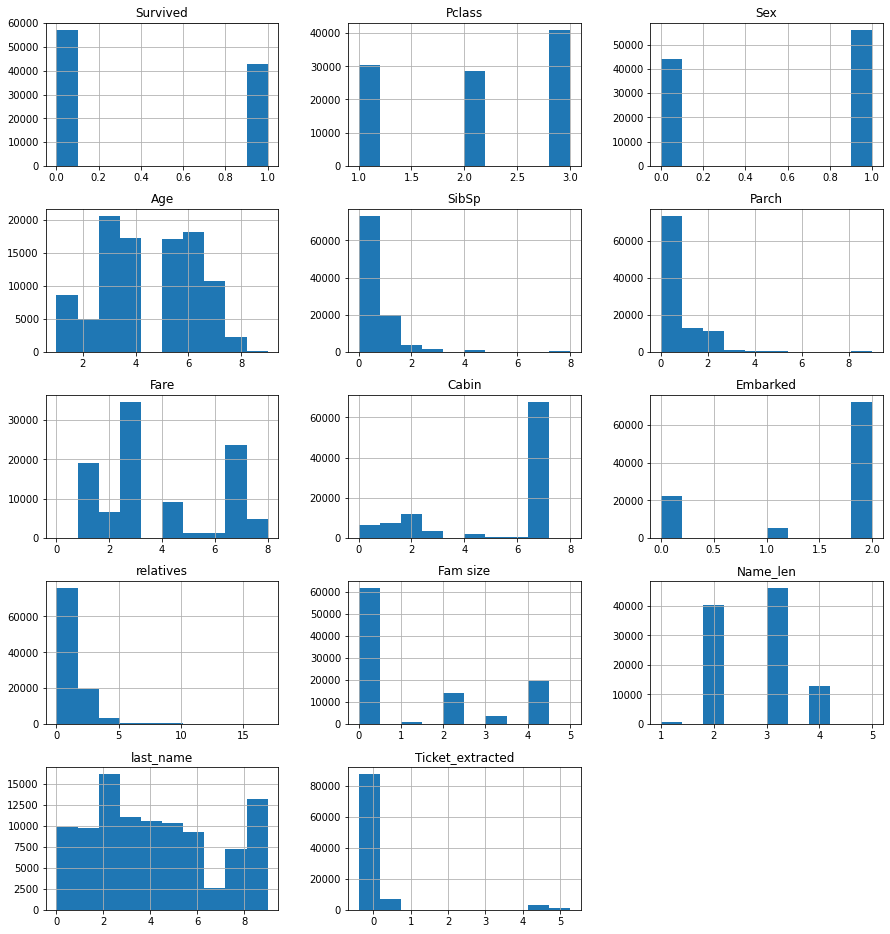

In [52]:
train_new.hist(figsize=(15, 30), layout=(9, 3));

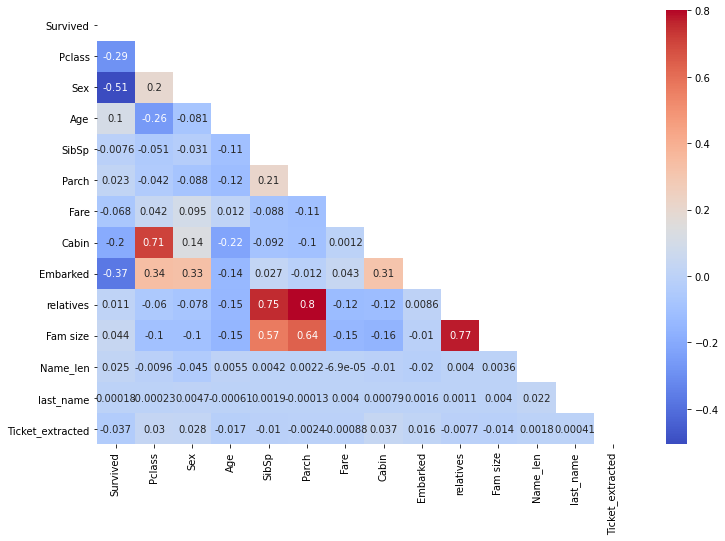

In [53]:
data_for_corr = train_new.corr()
corr_matrix = data_for_corr
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap="coolwarm")
plt.show();

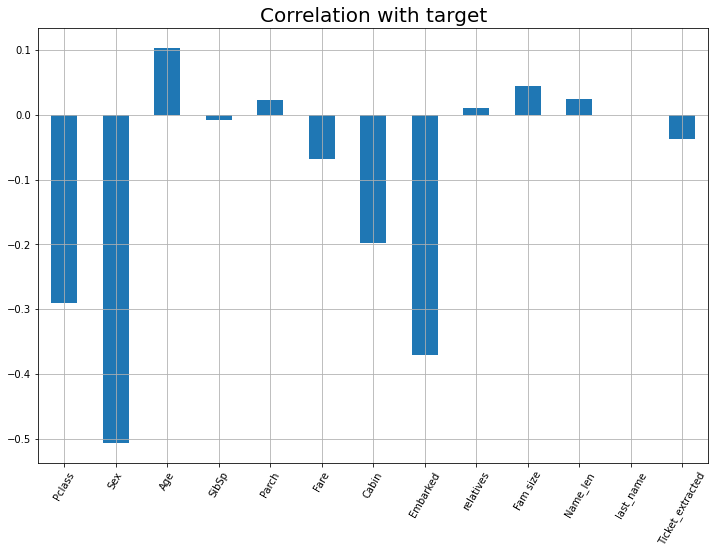

In [54]:
draw = train_new.drop(['Survived'], axis=1)
draw.corrwith(train_new['Survived']).plot(kind="bar", grid=True, figsize=(12, 8))
plt.title("Correlation with target", size=20)
plt.xticks(size=10, rotation=60)
plt.yticks(size=10)
plt.show();

In [55]:
train_new=pd.get_dummies(train_new, columns=['Pclass','Sex','Cabin','Embarked', 'Fam size', 'Name_len', 'last_name', 'Age', 'Fare'])
test_new=pd.get_dummies(test_new, columns=['Pclass','Sex','Cabin','Embarked', 'Fam size', 'Name_len', 'last_name', 'Age', 'Fare'])

In [56]:
train_new.head()

,Survived,SibSp,Parch,relatives,Ticket_extracted,Pclass_1,Pclass_2,Pclass_3,Sex_0,Sex_1,Cabin_0,Cabin_1,Cabin_2,Cabin_3,Cabin_4,Cabin_5,Cabin_6,Cabin_7,Cabin_8,Embarked_0,Embarked_1,Embarked_2,Fam size_0,Fam size_1,Fam size_2,Fam size_3,Fam size_4,Fam size_5,Name_len_1,Name_len_2,Name_len_3,Name_len_4,Name_len_5,last_name_0,last_name_1,last_name_2,last_name_3,last_name_4,last_name_5,last_name_6,last_name_7,last_name_8,last_name_9,Age_1.0,Age_2.0,Age_3.0,Age_4.0,Age_5.0,Age_6.0,Age_7.0,Age_8.0,Age_9.0,Fare_0,Fare_1,Fare_2,Fare_3,Fare_4,Fare_5,Fare_6,Fare_7,Fare_8
0,1,2,0,2,-0.137388,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,-0.363655,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,0,1,2,3,0.171633,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,-0.384123,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0.134235,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [57]:
#data_appended=train_new.append(test_new)
#data_appended

In [58]:
#data_appended=pd.get_dummies(data_appended, columns=['Name_len'])

In [59]:
#train_new=data_appended.iloc[0:100000]
#test_new=data_appended.iloc[100000:].drop('Survived', axis=1)

In [60]:
###Create final dataset for ML
X_train_data = train_new.drop(['Survived','SibSp','Parch','relatives'], axis=1)
y_train_data = train_new.Survived
test = test_new.drop(['SibSp','Parch','relatives'], axis=1)

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X_train_data, y_train_data, test_size=0.25, shuffle=True, random_state=42
)

print("X_train - ", X_train.shape)
print("y_train - ", y_train.shape)
print("X_validation - ", X_test.shape)
print("y_validation - ", y_test.shape)

X_train -  (75000, 57)
y_train -  (75000,)
X_validation -  (25000, 57)
y_validation -  (25000,)


In [62]:
model = XGBClassifier()
model.fit(X_train, y_train)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_train, y_train, scoring="accuracy", cv=cv, n_jobs=-1)
print("Mean accuracy score: %.5f" % np.mean(scores))

[00:42:08] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Mean accuracy score: 0.77903


In [63]:
y_predict = model.predict(X_test)
y_train_predict = model.predict(X_train)
accuracy_score(y_train, y_train_predict)
accuracy_score(y_test, y_predict)

0.8029866666666666

0.77856

In [64]:
#sorted(sklearn.metrics.SCORERS.keys())

In [65]:
submission = pd.DataFrame({'PassengerID':id_col,'Survived':model.predict(test).astype(int)})
submission.to_csv("./xgb.csv", index=False, header=True)

In [66]:
#submission

In [67]:
model_rs = XGBClassifier()
param_grid_rand = {
    "learning_rate": [0.001, 0.01, 0.05, 0.1, 0.5, 1, 10],
    "max_depth": [3, 5, 7, 10],
    "n_estimators": [100,250,500, 1000],
    "min_child_weight": [3, 5, 10],
    "gamma": [0.01, 0.1, 0.5, 1, 2, 5],
    "subsample": [0.6, 0.8, 0.9],
    "reg_alpha": [0, 0.5, 1],
    "reg_lambda": [1, 1.5, 2, 3, 4.5],
    "random_state": [42],
}


model_params_enc = RandomizedSearchCV(
    estimator=model_rs,
    param_distributions=param_grid_rand,
    n_iter=10,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
)

model_params_enc.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[01:47:05] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                           validate_parameters=None,
                                           verbosity=None),
                   n_jobs=-1,
                   par

In [68]:
print(model_params_enc.best_score_)
print(model_params_enc.best_params_)

0.7815333333333334
{'subsample': 0.6, 'reg_lambda': 2, 'reg_alpha': 1, 'random_state': 42, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 5}


In [69]:
y_predict = model_params_enc.best_estimator_.predict(X_test)
y_train_predict = model_params_enc.best_estimator_.predict(X_train)
accuracy_score(y_train, y_train_predict)
accuracy_score(y_test, y_predict)

0.7852266666666666

0.78196

In [70]:
submission = pd.DataFrame({'PassengerID':id_col,'Survived':model_params_enc.best_estimator_.predict(test).astype(int)})
submission.to_csv("./xgb_addedcols_params.csv", index=False, header=True)

In [71]:
print(model_params_enc.best_estimator_.feature_importances_)


[0.00520418 0.00436324 0.00839624 0.08384485 0.4132476  0.
 0.04030482 0.00397782 0.01651924 0.00633919 0.00360727 0.00697012
 0.00465722 0.05394693 0.         0.10126688 0.0057366  0.07111052
 0.00823149 0.00341716 0.00421827 0.00882879 0.00804089 0.
 0.00299205 0.0027357  0.00282237 0.0020949  0.         0.00259043
 0.00290303 0.00277027 0.00314769 0.00233747 0.00279299 0.00176588
 0.00241912 0.00299003 0.00237098 0.00802376 0.00288426 0.00344744
 0.00386486 0.00398019 0.00260949 0.00260391 0.00232994 0.
 0.         0.00509748 0.00498124 0.01781023 0.00580854 0.0031352
 0.00321639 0.01718121 0.01406369]


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

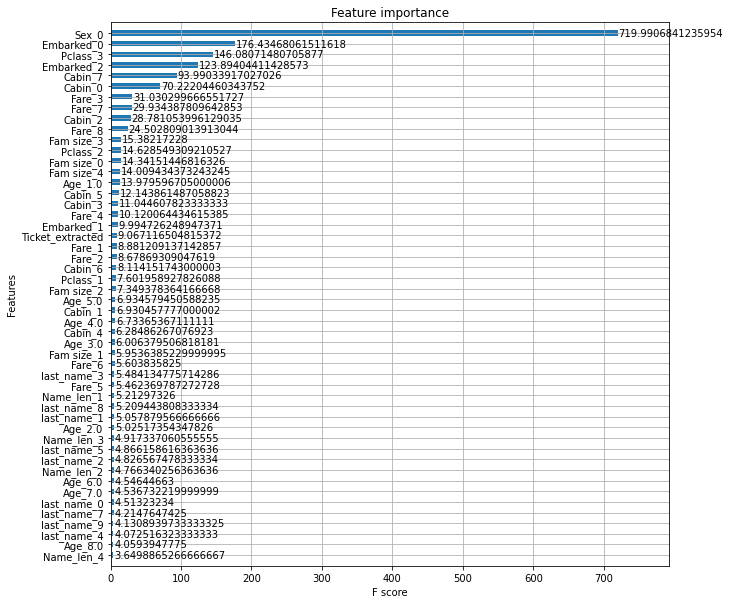

In [72]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(model_params_enc.best_estimator_, max_num_features=50, height=0.5, ax=ax,importance_type='gain')
plt.show()

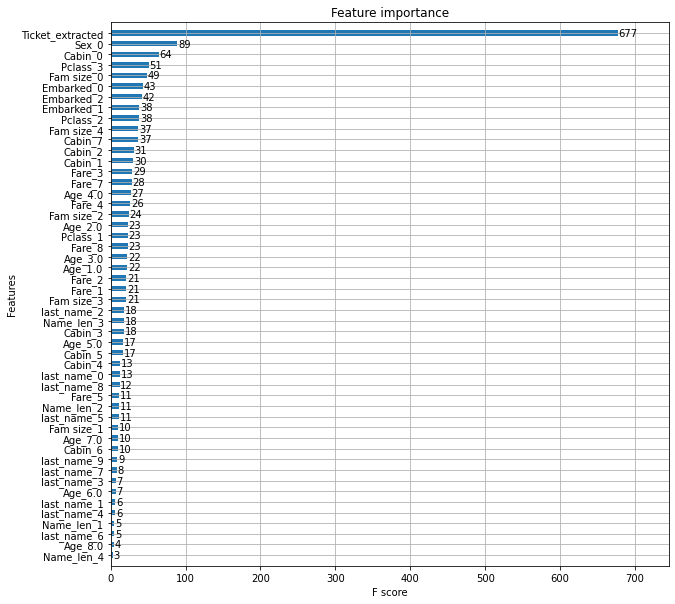

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
plot_importance(model_params_enc.best_estimator_, max_num_features=50, height=0.5, ax=ax,importance_type='weight')
plt.show();

from numpy import sort
from sklearn.feature_selection import SelectFromModel

thresholds = sort(model_params_enc.best_estimator_.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model_params_enc.best_estimator_, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test)
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    accuracy = accuracy_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

In [74]:
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
print("Mean accuracy score: %.5f" % np.mean(score))

LGBMClassifier()

Mean accuracy score: 0.78128


In [75]:
y_pred=model.predict(X_test)
accuracy=accuracy_score(y_pred, y_test)
print('LightGBM Model Test accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred)))

LightGBM Model Test accuracy score: 0.7809


In [76]:
y_pred_train = model.predict(X_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.7892


In [77]:
submission = pd.DataFrame({'PassengerID':id_col,'Survived':model.predict(test).astype(int)})
submission.to_csv("./lbgm.csv", index=False, header=True)

In [78]:
!pip install -U lightautoml

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler


     |████████████████████████████████| 236 kB 1.2 MB/s 
     |████████████████████████████████| 1.2 MB 4.9 MB/s 
     |████████████████████████████████| 232 kB 6.5 MB/s 
     |████████████████████████████████| 424 kB 6.5 MB/s 
     |████████████████████████████████| 204 kB 6.9 MB/s 
     |████████████████████████████████| 2.8 MB 6.7 MB/s 
     |████████████████████████████████| 89 kB 4.2 MB/s 
     |████████████████████████████████| 96 kB 3.3 MB/s 
     |████████████████████████████████| 84 kB 2.4 MB/s 
     |████████████████████████████████| 93 kB 1.6 MB/s 
     |████████████████████████████████| 121 kB 10.2 MB/s 
     |████████████████████████████████| 90 kB 5.3 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.0-py3-none-any.whl size=16033 sha256=21c3f06465176a128af1afff556bb941e47b77df4aa67ca64ea7105918e5dea0
  Stored in directory: /root/.cache/pip/wheels/b7/cc/0d/41d384b0071c6f46e542aded5f8571700ace4f1eb3f1591c29
  Created wheel for json2html: file

In [79]:
from sklearn.metrics import accuracy_score, f1_score
def acc_score(y_true, y_pred, **kwargs):
    return accuracy_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

def f1_metric(y_true, y_pred, **kwargs):
    return f1_score(y_true, (y_pred > 0.5).astype(int), **kwargs)

task = Task('binary', metric = f1_metric)

In [80]:
N_THREADS = 4 # threads cnt for lgbm and linear models
N_FOLDS = 5 # folds cnt for AutoML
RANDOM_STATE = 42 # fixed random state for various reasons
TEST_SIZE = 0.25 # Test size for metric check
TIMEOUT = 36000 # Time in seconds for automl run

In [81]:
import torch
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [82]:
roles = {
    'target': 'Survived',
    'drop': ['SibSp','Parch','relatives']
}

In [83]:
automl = TabularUtilizedAutoML(task = task, 
                       timeout = TIMEOUT,
                       cpu_limit = N_THREADS,
                       general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned']]},
                       reader_params = {'n_jobs': N_THREADS})
oof_pred = automl.fit_predict(train_new, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred[:10], oof_pred.shape))

Current random state: {'reader_params': {'random_state': 42}}
Found reader_params in kwargs, need to combine
Merged variant for reader_params = {'n_jobs': 4, 'random_state': 42}
Start automl preset with listed constraints:
- time: 35999.997611522675 seconds
- cpus: 4 cores
- memory: 16 gb

Train data shape: (100000, 61)
Feats was rejected during automatic roles guess: []


Layer 1 ...
Train process start. Time left 35961.361669778824 secs
Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
Linear model: C = 1e-05 score = 0.6976170378546848
Linear model: C = 5e-05 score = 0.7228856029202501
Linear model: C = 0.0001 score = 0.7256191237018375
Linear model: C = 0.0005 score = 0.7282132424537487
Linear model: C = 0.001 score = 0.7285219188909832
Linear model: C = 0.005 score = 0.728851642679298
Linear model: C = 0.01 score = 0.728851642679298
Linear model: C = 0.05 score = 0.7290060112939463
Linear model: C = 0.1 score = 0.7290060112939463
Linear model: C = 0.5 score = 0.7290060112939463
Linear 

Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer


Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.468568	valid's Opt metric: 0.739674
[200]	valid's binary_logloss: 0.465979	valid's Opt metric: 0.742202
[300]	valid's binary_logloss: 0.467146	valid's Opt metric: 0.741202
Early stopping, best iteration is:
[185]	valid's binary_logloss: 0.465827	valid's Opt metric: 0.742307
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Training until validation scores don't improve for 200 rounds
[100]	valid's binary_logloss: 0.469927	valid's Opt metric: 0.740657
[200]	valid's binary_logloss: 0.466738	valid's Opt metric: 0.741203
[300]	valid's binary_logloss: 0.467996	valid's Opt metric: 0.741075
Early stopping, best iteration is:
[189]	valid's binary_logloss: 0.466719	valid's Opt metric: 0.740899
Lvl_0_Pipe_1_Mod_1_LightGBM fitting and predicting completed
Start fitting Lvl_0_Pipe_1_Mod_1_LightGBM ...
Tr

In [84]:
test_pred = automl.predict(test)
print('Prediction for test data:\n{}\nShape = {}'.format(test_pred[:10], test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(acc_score(train_new['Survived'].values, oof_pred.data[:, 0])))

Prediction for test data:
array([[0.09551577],
       [0.36003906],
       [0.9018022 ],
       [0.19513032],
       [0.76905453],
       [0.29397047],
       [0.804052  ],
       [0.08228263],
       [0.57437825],
       [0.06991509]], dtype=float32)
Shape = (100000, 1)
Check scores...
OOF score: 0.78248


In [85]:
submission['Survived'] = (test_pred.data[:, 0] > 0.5).astype(int)
submission.to_csv('automl.csv', index = False)

**Score is 0.78655**

In [86]:
#def objective(trial, data = X_train_data, target = y_train_data):
#    X_train, X_val, y_train, y_val = train_test_split(X_train_data, y_train_data, test_size = 0.25, random_state = 42)

#    params = {
#        'reg_alpha': trial.suggest_float('reg_alpha', 0.001, 10),
#        'reg_lambda': trial.suggest_float('reg_lambda', 0.001, 10.0),
#        'num_leaves': trial.suggest_int('num_leaves', 10, 100),
#        'max_bin': trial.suggest_int('max_bin', 10, 1000),
#        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#        'max_depth': trial.suggest_int('max_depth', 3, 10),
#        'learning_rate': trial.suggest_float('learning_rate', 0.0001, 0.25),
#        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 0.6),
#        'min_data_per_group': trial.suggest_int('min_data_per_group', 50, 200),
#        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
#        'num_iterations': trial.suggest_int('num_iterations', 100, 1000),
#        'boosting': 'dart',
#        'random_state': 42,
#        'metric': 'binary_logloss',
#    }
    
#    model = lgb.LGBMClassifier(**params)  
#    model.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 100, verbose = False)
#    y_pred = model.predict(X_val)
    
#    accuracy = accuracy_score(y_val, y_pred)
    
#    return accuracy

#study = optuna.create_study(direction = 'maximize')
#study.optimize(objective, n_trials = 300)
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)
#print('Best value:', study.best_value)

#paramsLGBM = study.best_trial.params
#params = {'random_state': 42, 'metric': 'binary_logloss'}

#paramsLGBM.update(params)

In [87]:
#paramsLGBM
#print('Number of finished trials:', len(study.trials))
#print('Best trial:', study.best_trial.params)
#print('Best value:', study.best_value)

In [88]:
#folds = KFold(n_splits = 10, shuffle = True, random_state = 42)
#predictions = np.zeros(len(test))
#for fold, (trn_idx, val_idx) in enumerate(folds.split(X_train_data, y_train_data)):
    
#    X_train, X_val = X_train_data.iloc[trn_idx], X_train_data.iloc[val_idx]
#    y_train, y_val = y_train_data.iloc[trn_idx], y_train_data.iloc[val_idx]

#    model = lgb.LGBMClassifier(**paramsLGBM)
   
#    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose = False, early_stopping_rounds = 100)
    
#    predictions += model.predict_proba(test)[:,1] / folds.n_splits 

In [89]:
#sns.histplot(predictions)
#plt.show()

In [90]:
#submission = pd.DataFrame({'PassengerId': id_col, 'Survived': np.where(predictions > 0.5, 1, 0)})
#submission.to_csv('submissionLGBM.csv', index = False)

In [91]:
#submission = pd.DataFrame({'PassengerId': id_col, 'Survived': np.where(predictions > 0.45, 1, 0)})
#submission.to_csv('submissionLGBM_45.csv', index = False)